# TP 2 - Bandit Algorithms (November 23)

In this assignement, we will focus on the MultiArmed Bandits problem.
You will implement:


- Deterministic policy UCB1 normal  https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf or Chapter 7 of Bandit Algorithms

- Boltzmann Exploration (Softmax) https://www.cs.mcgill.ca/~vkules/bandits.pdf

- KL-UCB https://hal.archives-ouvertes.fr/hal-00738209v2 or Chapter 10.2 of Bandits Algorithm

- Best Empirical Sampled Average (BESA) https://hal.archives-ouvertes.fr/hal-01025651v1/document 

- Thompson Sampling Agent  https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf, https://en.wikipedia.org/wiki/Thompson_sampling or Chapter 35 and 36 of Bandits Algorithms


![image not found:](multiarmedbandit.jpg "Bandits")

You will be evaluated on:
* Implementation of the agents. Points will be granted to clean, scalable code.
* A small paragraph with an analysis of the behavior of the agent and your understanding of the algorithm
* Answering this question -> for each implemented agent, give 1 pros and 1 cons ?

Send this notebook  to cyriaque.rousselot@inria.fr before next course.

Good Luck !

## Example : Random Agent and Epsilon Greedy Agent


In `choose`, prescribe how the agent selects its
actions (interact must return an action, that is
an index in `[0, ..., n_a]`).

In `update`, implement how the agent updates
its knowledge, using the newly observed `action` and `reward`.

In [1]:
import runner2 as runner
import environment
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style("whitegrid")

sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

## I created some additional methods to facilitate the grid exploration of different parameters

In [3]:
def get_cummulative_values(env, agent, niter, n_agents, n_actions, env_args =None, agent_args = None, verbose=False): 
    my_runner = runner.BatchRunner(
        env,
        agent,
        n_agents,
        n_actions,
        env_args,
        agent_args,
        verbose=verbose,
    )
    final_reward, list_cumul = my_runner.loop(niter)
    return list_cumul

In [4]:
def append_cummulative_list(experimental_results, list_cumul, key, agent_name, param_name, param_value): 
    experimental_results[key].append({
                    "cum_reward_list" :list_cumul,
                    "agent_name": agent_name,
                    "param" : {
                        "name": param_name,
                        "value": param_value
                    }
                })

In [5]:
def plot_cummulative_values(experimental_results, rows, columns):
        
        fig, axs = plt.subplots(rows, columns, figsize=(16, 18))
        
        for i, key in enumerate(experimental_results.keys()): 

            # Always on the first column
            if key[0] == environment.EasyEnvironment:

                ax = axs[i, 0] if columns == 2 else axs[i]
                ax.set_title("{}(variability {}, n_actions {})".format(key[0].__name__, key[1], key[2]))

                for j, result in enumerate(experimental_results[key]):
                    ax.plot(result["cum_reward_list"], label="{} {} {}".format(result["agent_name"],result["param"]["name"], result["param"]["value"]))

                ax.legend()
            else:
                ax = axs[i - rows, 1] if columns == 2 else axs[i - rows]

                ax.set_title("{}(variability {}, n_actions {})".format(key[0].__name__, key[1], key[2]))

                for j, result in enumerate(experimental_results[key]): 
                    ax.plot(result["cum_reward_list"], label="{} {} {}".format(result["agent_name"], result["param"]["name"], result["param"]["value"]))

                ax.legend()

In [6]:
def grid_search(niter,n_agents, baseline_agent, agent, agent_args, avoid_hard_env=False, variabilities=None, n_actions_list=None):
    experimental_results = {}

    if avoid_hard_env:
        envs = [environment.EasyEnvironment]
    else:
        envs = [environment.EasyEnvironment, environment.HardEnvironment]


    for env in envs:
        for variability in variabilities: 
            for n_actions in n_actions_list: 


                experimental_results[(env, variability, n_actions)] = []  

                list_cumul = get_cummulative_values(env, baseline_agent, niter, n_agents, n_actions, {"variability": variability}, None, verbose=False)
                append_cummulative_list(experimental_results, list_cumul, (env, variability, n_actions), "RandomAgent", "", "")

                if agent_args is not None:

                    keys = list(agent_args.keys())

                    for value in agent_args[keys[0]]:
                        list_cumul = get_cummulative_values(env, agent, niter, n_agents, n_actions, {"variability": variability}, {keys[0]: value}, verbose=False)
                        append_cummulative_list(experimental_results, list_cumul, (env, variability, n_actions), agent.__name__, keys[0], value)

                else: 
                    list_cumul = get_cummulative_values(env, agent, niter, n_agents, n_actions, {"variability": variability}, None, verbose=False)
                    append_cummulative_list(experimental_results, list_cumul, (env, variability, n_actions), agent.__name__, "", "")  
    

    return experimental_results

In [7]:
def experiment_values(niter,n_agents, baseline_agent, agent, agent_args, avoid_hard_env=False): 

    variabilities = [0.1, 1]
    n_actions_list = [10, 100]
              
    experimental_results = grid_search(niter,n_agents, baseline_agent, agent, agent_args, avoid_hard_env, variabilities, n_actions_list)

    rows = len(n_actions_list) * len(variabilities)
    columns = 2 if not avoid_hard_env else 1

    plot_cummulative_values(experimental_results, rows, columns)

### Agent Definition

In [8]:
class RandomAgent:
    def __init__(self, n_a):
        self.n_a = n_a  # number of possible actions
        """Init a new agent.
        """
        self.mu = {a: [] for a in range(n_a)}

    def choose(self):
        """Acts in the environment.

        returns the chosen action.
        """
        return np.random.randint(0, self.n_a)

    def update(self, action, reward):
        """Receive a reward for performing given action on
        given observation.

        This is where your agent can learn.
        """
        
        self.mu[action].append(reward)
        

### General idea

With a probability of 1- $\epsilon$, the agent will always choose the action with the higher probability (exploit) and with a probability of $\epsilon$ the agent will choose randomly an action (exploration)

<b>Pros</b>: it is straightforward and you ensure both explorations and exploitation 

<b>Cons</b>: when it explores, it is exploring randomly any of the actions even if some are relatively poor choices

In [48]:
class epsGreedyAgent:
    def __init__(self, n_a, epsilon):
        self.n_a = n_a  # number of possible actions
        self.A = range(n_a)
        self.mu = {a: [] for a in self.A}
        self.epsilon = epsilon

        # print(self.mu.keys())

    def choose(self):
        """Acts in the environment.

        returns the chosen action.
        """

        if np.random.random() > self.epsilon:
            # Exploit

            list_mean = [np.mean(self.mu[action]) if self.mu[action] != [] else -np.infty for action in self.A]


            return np.argmax(list_mean)
        else: 
            # Explore
            return np.random.randint(0, self.n_a)


    def update(self, action, reward):
        """Receive a reward for performing given action on
        given observation.

        This is where your agent can learn.
        """

        self.mu[action].append(reward)



### Agent Evaluation

There exists two classes from the ```environment``` package, ```environment.EasyEnvironment``` and ```environment.HardEnvironement```. Try the agents on both for your analysis.

The Environment Class takes two arguments: ```n_a``` the number of actions and ```variability```, a parameter between 0 and 1 that influence the spreading of distribution of the reward between bandits.

You can play with the complexity of the environment by modifying the number of possible actions and variances of the reward distributions . I suggest that you begin with 10 possible actions

In [16]:
# Running a batched simulation with n_agents agents in parallel

niter = 1000
n_agents = 10
n_actions = 10
variability = 0.5
my_runner = runner.BatchRunner(
    environment.EasyEnvironment,
    epsGreedyAgent,
    n_agents,
    n_actions,
    {"variability": variability},
    {"epsilon": 0.1},
    verbose=False,
)
final_reward_rd, list_cumul_rd = my_runner.loop(niter)
print("Random Agent obtained a final average reward of {}".format(final_reward_rd))

Random Agent obtained a final average reward of 646.7000000000011


In [17]:
# Running a batched simulation with n_agents agents in parallel

niter = 1000
n_agents = 10
n_actions = 30
variability = 1

my_runner = runner.BatchRunner(
    environment.EasyEnvironment, 
    RandomAgent, 
    n_agents, 
    n_actions, 
    {"variability": variability},
    None, 
    verbose=False
)
final_reward_rd, list_cumul_rd = my_runner.loop(niter)
print("Random Agent obtained a final average reward of {}".format(final_reward_rd))

Random Agent obtained a final average reward of 494.40000000000015


> Analysis of Epsilon Greedy

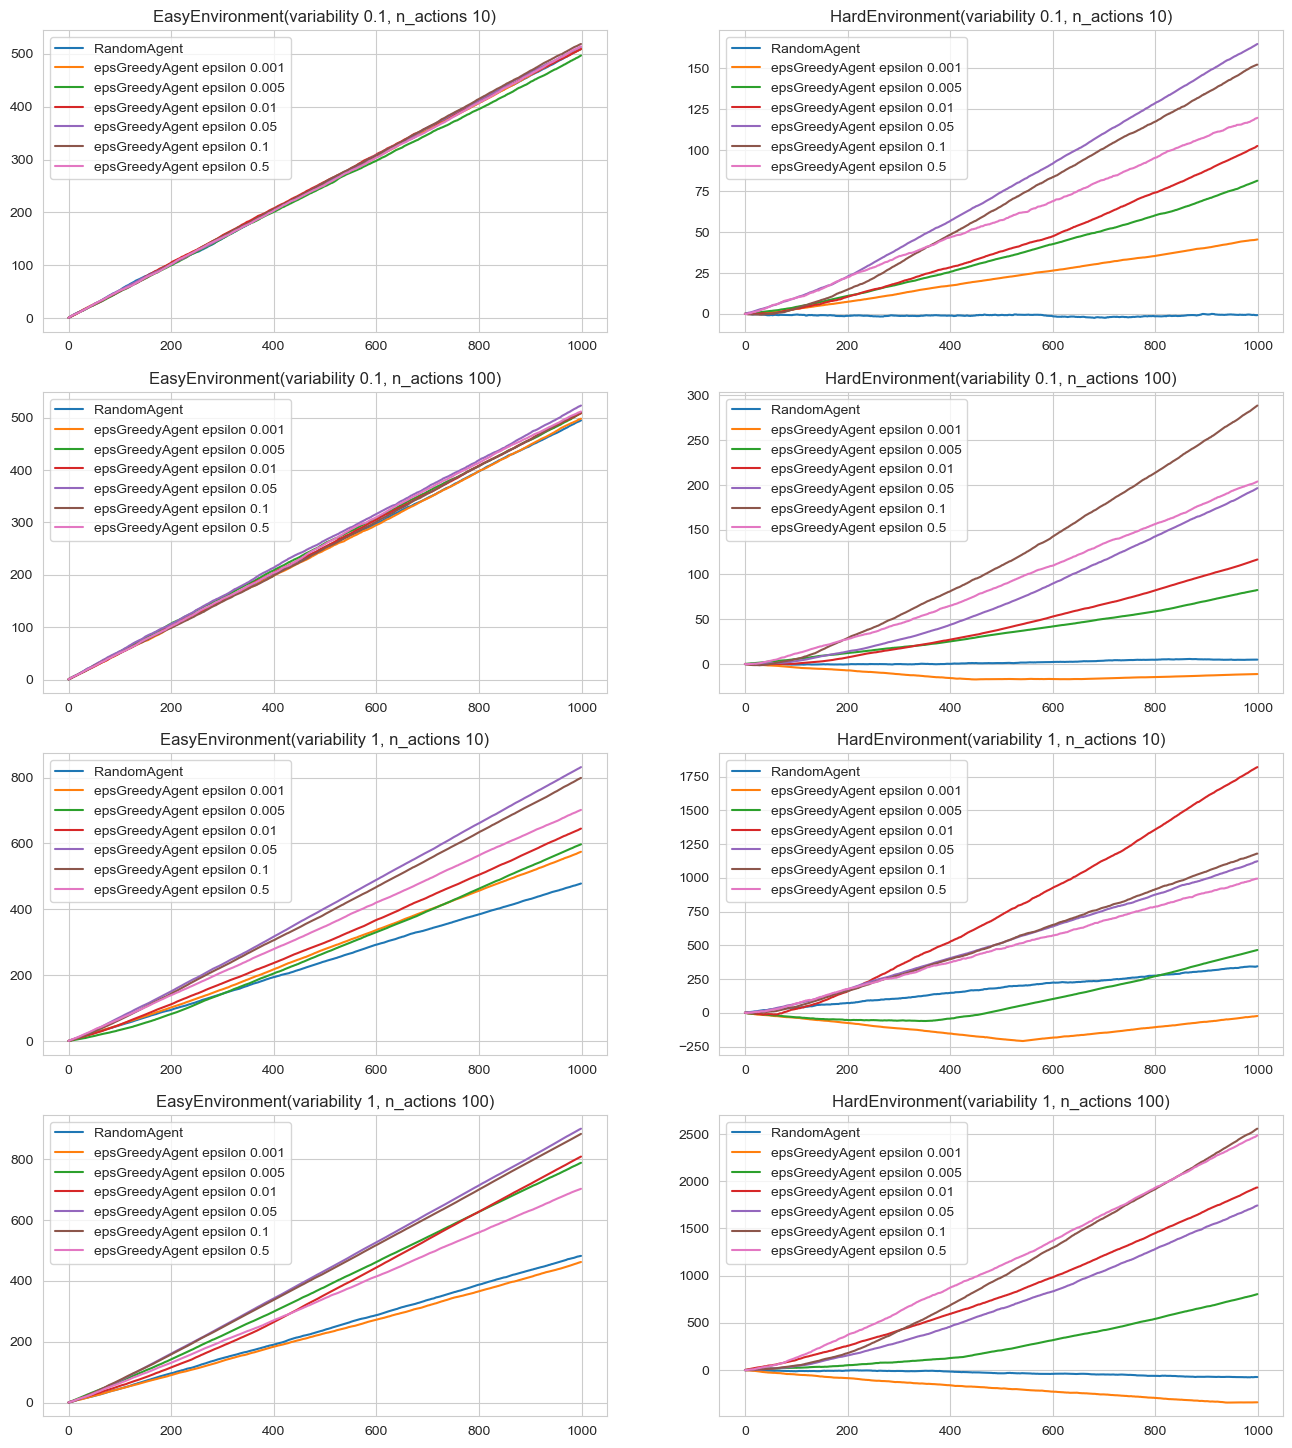

In [51]:
experiment_values(1000, 10, RandomAgent, epsGreedyAgent, {"epsilon": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]})

* In the Easy environment, the epsilon greedy agents perform much better in models with higher variability

* In Hard environments with low variability, exploratory approaches with higher epsilon seem to be more efficient. This result is intuitive because the search space is not that big and it does not take too much time to explore all the possibilities. 


### UCB-1

### General idea 

Each are is played once to initialize the average reward. Afterwards, we select the next arm based on the following rule: 

\begin{align}
 arm_i = \overline{r_i} + \sqrt{\frac{2*ln(t)}{n_i}}
\end{align}

Where $r_i$ is the current average reward of arm i, $t$ is the total number of plays at that current time and $n_i$ is the number of times arm i was played. The second term provides information about the uncertainty (variance) in the estimation of each arm. It decreases the more times we play the respective arm. The general idea behind the second term is that if the variance is high, it should encourage the agent to explore as there is a higher chance to get a bigger reward (as the upper confidence bound is higher).

<b>Pros</b>: We don't need any prior knowledge of the reward distribution


<b>Cons</b>: It can underperform if the variance of the rewards are too high as the confidence bound will not represent accurately the uncertainty

In [52]:
class UCBAgent:
    # https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf
    def __init__(self, n_actions):
        self.A = range(n_actions)
        self.mu = {a: [] for a in self.A}
        self.N = {a: 0 for a in self.A}
        self.t = 0


    def choose(self):
        """Acts in the environment.

        returns the chosen action.
        """
        
        self.t += 1

        list_mean = []
        for action in self.A: 
            if self.N[action] == 0: # choose each action at least once
                return action

            mean = np.mean(self.mu[action])

            if np.isnan(mean): # it is less likely to happen as we already chose each action at least once, but better safe than sorry
                mean = -np.infty
            
            list_mean.append(mean + np.sqrt(2*np.log(self.t)/self.N[action]))

        return np.argmax(list_mean)

    def update(self, a, r):
        """Receive a reward for performing given action on
        given observation.

        This is where your agent can learn.
        """
        
        self.mu[a].append(r)
        self.N[a] += 1
        

In [53]:
niter = 1000
n_agents = 10
n_actions = 10
variability = 1
my_runner = runner.BatchRunner(
    environment.EasyEnvironment,
    UCBAgent,
    n_agents,
    n_actions,
    {"variability": variability},
    None,
    verbose=False,
)
final_reward_rd, list_cumul_rd = my_runner.loop(niter)
print("UCBAgent obtained a final average reward of {}".format(final_reward_rd))



UCBAgent obtained a final average reward of 784.3999999999946


> Analysis of UCB1

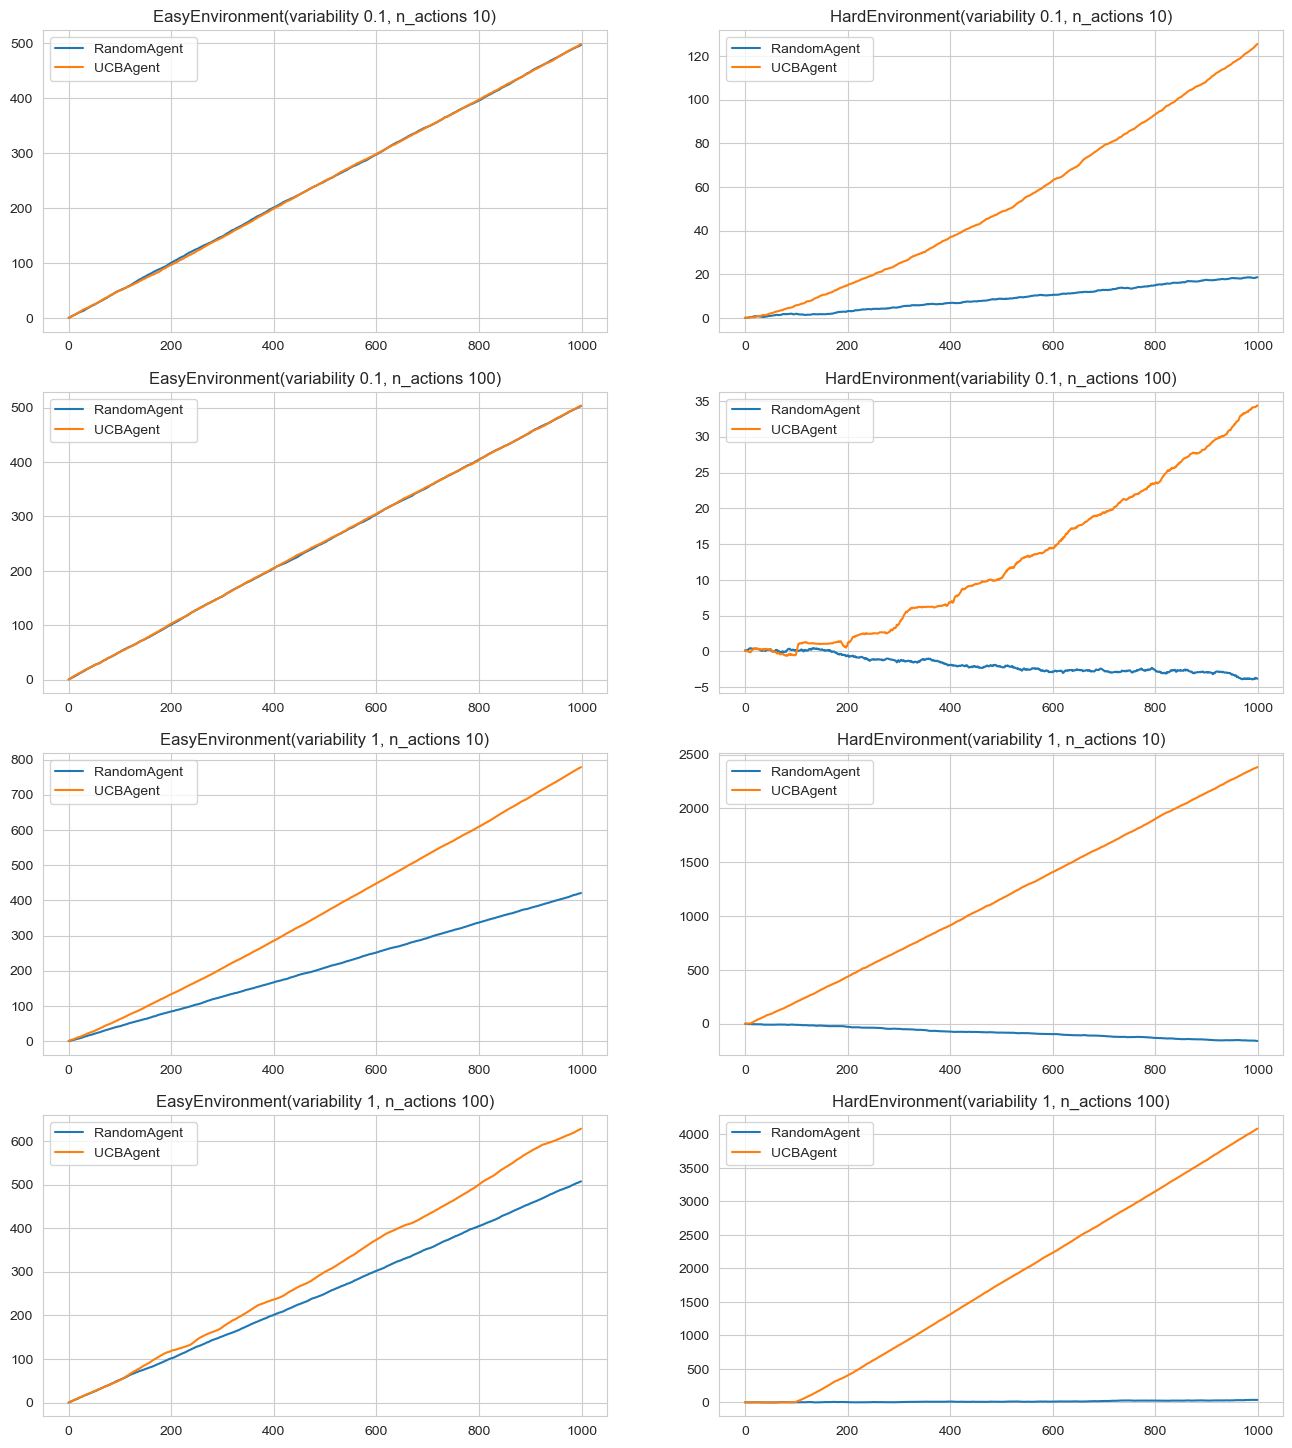

In [54]:
experiment_values(1000, 10, RandomAgent, UCBAgent, None)

* In the Easy environment, the Uppper Confidence Bound performs relatively the same with the Random Agent. The result is expected as the environment is so small that even random decision can bring the same reward. Unlike epsGreedy, the UCB agent is slightly underperforming in the scenarios with higher variability 

* In the HardEnvironment, the UCB agent almost doubles the reward in the high variability scenarios, compared to epsGreedy. The fact that we choose to explore an arm also based on the future (possible) upper bound reward is making each exploration count (unlike a chaotic random exploration). However, it underperforms in the scenarios with low variability and multiple actions. Overall, UCB seems to depend on high variability in order to perform well

### Boltzmann Exploration (Softmax) 

### General idea

Boltzman Exploration is trying to control the exploration/exploitation by introducing a temperature parameter. A high temperature encourages more exploration, meanwhile a low temperature is more prone to exploitation. Each action is selected based on a probability distribution which is generated by applying softmax on the current estimated rewards with respect to the temperature. The higher the probability of an action, the more chances for the respective action to be chosen. 

\begin{align}
    P(a) = \frac{e^{\frac{Q(a)}{T}}}{\sum_{b} e^{\frac{Q(b)}{T}}}
\end{align}

<b> Pros</b>: the temperature parameter offers adaptability as we can fine-tune it according to the constraints of the problem (environment)

<b> Cons</b>: it is very sensitive related to the choice of the temperature and it can take a lot of time to find a suitable value that can balance the exploration and exploitation



In [21]:
class SoftmaxAgent:  # Chose a Temperature between 0.01 and 1
    # https://www.cs.mcgill.ca/~vkules/bandits.pdf
    def __init__(self, n_actions, temperature = 0.1):
        self.A = range(n_actions)
        self.temperature = temperature
        self.mu = {a: [] for a in self.A}
        self.N = {a: 0 for a in self.A}

    def softmax(self, x):
        """Compute softmax values for each set of scores in x."""

        #The softmax is controled by the temperature
        #Higher temperature means more exploration
        #Lower temperature means more exploitation
        x = np.array(x)
        e_x = np.exp((x - np.max(x)) / self.temperature)
        return e_x / e_x.sum()

    def choose(self):
        """Acts in the environment.

        returns the chosen action.
        """
        empirical_means = [np.mean(self.mu[a]) if self.N[a] > 0 else 0 for a in self.A]

        # Obtain the probabilities of each action
        probabilities = self.softmax(empirical_means)

        #Make a random choice according to the probabilities
        action = np.random.choice(self.A, p=probabilities)
        
        return action

    def update(self, action, reward):
        """Receive a reward for performing given action on
        given observation.

        This is where your agent can learn.
        """
        
        # Add the reward to the list of rewards for the action
        self.mu[action].append(reward)
        # Increment the number of times the action was chosen
        self.N[action] += 1

In [22]:
niter = 1000
n_agents = 10
n_actions = 10
variability = 1
my_runner = runner.BatchRunner(
    environment.EasyEnvironment,
    SoftmaxAgent,
    n_agents,
    n_actions,
    {"variability": variability},
    {"temperature": 0.1},
    verbose=False,
)
final_reward_rd, list_cumul_rd = my_runner.loop(niter)
print("Boltzmann Exploration obtained a final average reward of {}".format(final_reward_rd))

Boltzmann Exploration obtained a final average reward of 789.9999999999953


> Analysis of Boltzmann Exploration

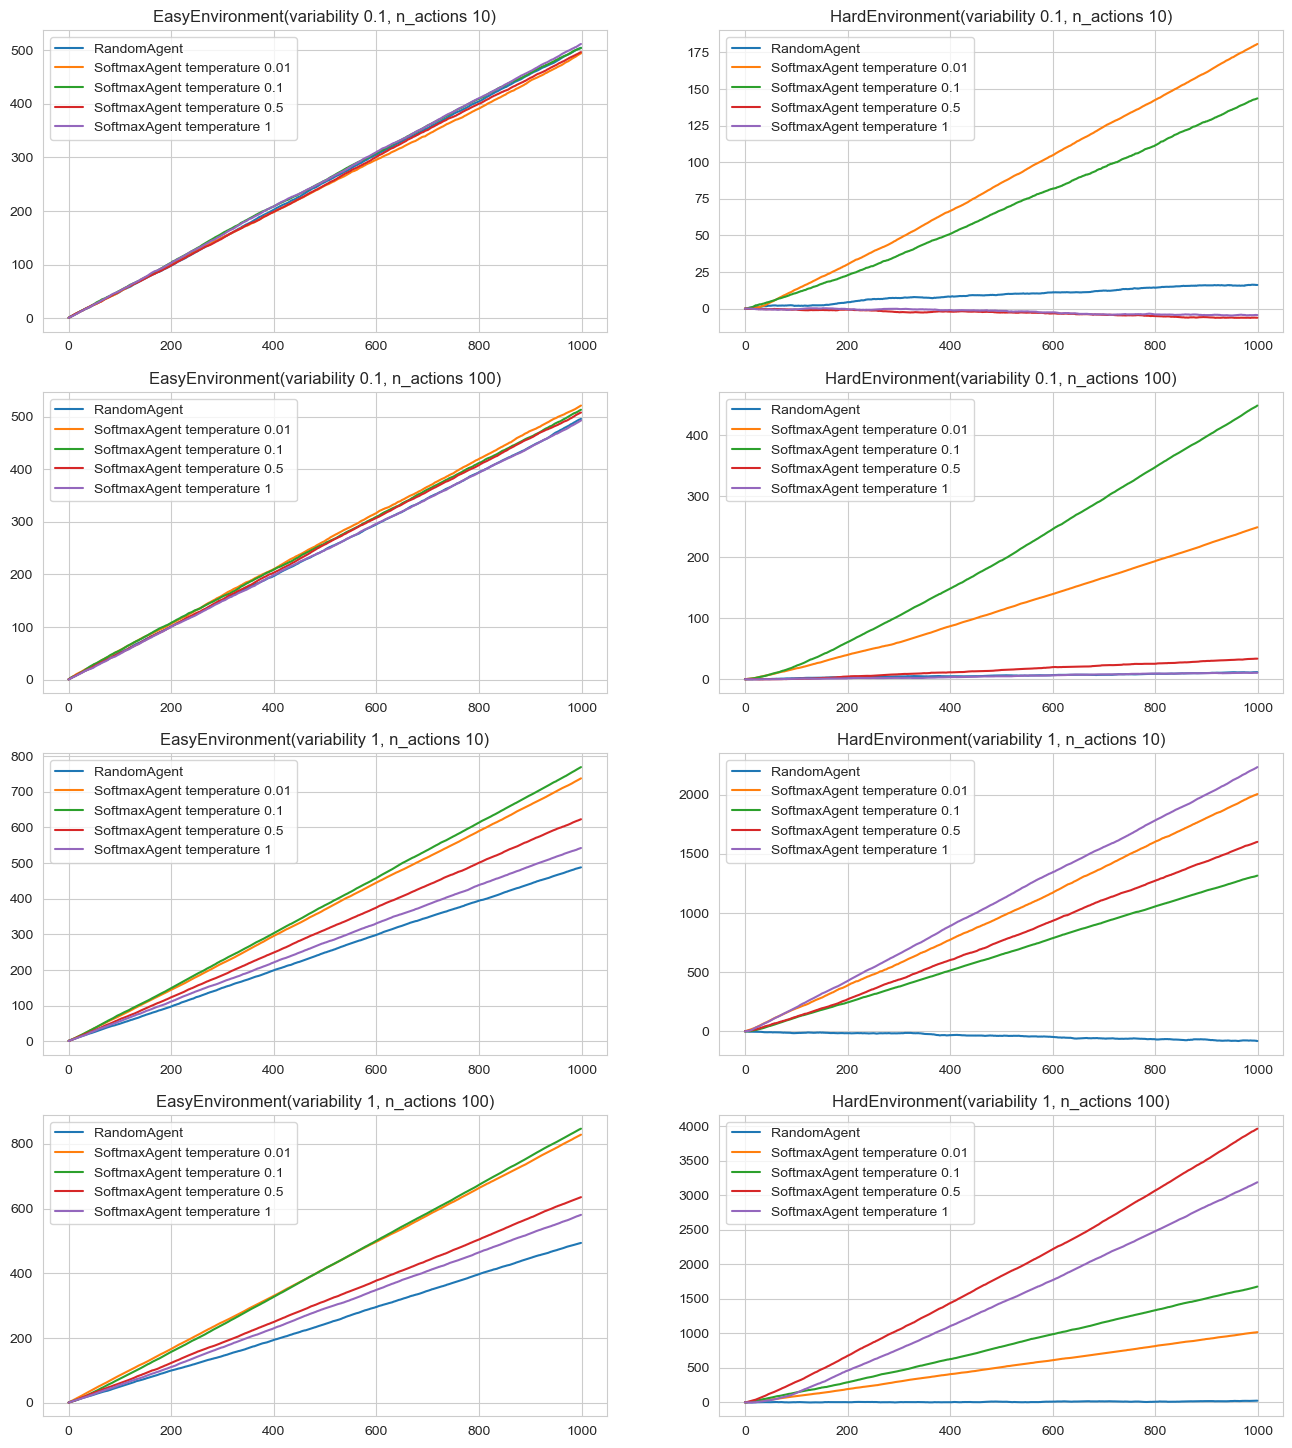

In [23]:
experiment_values(1000, 10,RandomAgent, SoftmaxAgent, {"temperature": [0.01, 0.1, 0.5, 1]})

* In the Easy environment, a smaller temperature is usually performing better, no matter the variability and the number of actions. A lower temperature is making the agent more prone to the exploitation which seems more suitable in an environment where the rewards are not ranging a lot. 

* In the Hard environment, agents with higher temperature perform much better as they explore more often. The scores are pretty much the same with the ones of the upper confidence bound

### BESA

### General idea

BESA is trying to impose a fair comparison between two arms by compensating for the different number of previous trials each arm had. If one arm was chosen more times than the other one, comparing directly their mean estimated reward wouldn't be fair. Therefore, we sample without replacement from the values of the arm which had multiple trials such that we have an equal number of samples between the two arms and only then we compare the estimated rewards. Because we work with multiple arms, we will make a tournament in which we compare arms two by two until one of them remains. 

<b> Pros </b>: no parameter tuning, it adapts to various environments as it does not need prior knowledge of the distributions and it remains invariant under rescaling

<b> Cons </b>: subsampling may slow down the search if we have a huge number arms from where we need to choose

In [24]:
import random 

class BesaAgent:
    # https://hal.archives-ouvertes.fr/file/index/docid/1025651/filename/BESA2.pdf
    def __init__(self, n_actions):
        self.A = range(n_actions)
        self.mu = {a: [] for a in self.A}
        self.N = {a: 0 for a in self.A}

    def sample_wr(self, action, k):
        """Samples k rewards for the given action without replacement."""
        return random.sample(self.mu[action], k)

    def compare_two_arms(self, a, b): 

        if self.N[a]>0 and self.N[b]>0:

            #find the minimum number of times the arms have been played
            sample_size = min(self.N[a], self.N[b])

            #sample without replacement such that we have the same number of samples for each arm
            #the arm with less samples will select everything
            samples_a = self.sample_wr(a, sample_size)
            samples_b = self.sample_wr(b, sample_size)

            #compute the mean of the samples
            mean_a = np.mean(samples_a)
            mean_b = np.mean(samples_b)

            #return the arm with the highest mean
            return a if mean_a > mean_b else b
        else:
            #if the arm has not been played yet, we play it
            return a if self.N[a] == 0 else b

    def choose(self):
        """Acts in the environment.

        returns the chosen action.
        """
        arms = list(self.A)

        while len(arms) > 1:
            next_round_arms = []

            # I do this to avoid the recursive call 
            # we compare two arms at a time and we keep the best one 
            # we repeat until we have only one arm left
            for i in range(0, len(arms), 2):
                if i+1 < len(arms):
                    #if we have an even number of arms, we compare them two by two
                    next_round_arms.append(self.compare_two_arms(arms[i], arms[i+1]))
                else:
                    #if we have an odd number of arms, we keep the last one by default
                    next_round_arms.append(arms[i])
            
            arms = next_round_arms
        
        # The final arm is the one we chose
        return arms[0]

    def update(self, action, reward):
        """Receive a reward for performing given action on
        given observation.

        This is where your agent can learn.
        """
        
        # Add the reward to the list of rewards for the action
        self.mu[action].append(reward)
        # Increment the number of times the action was chosen
        self.N[action] += 1

> Analysis of BESA

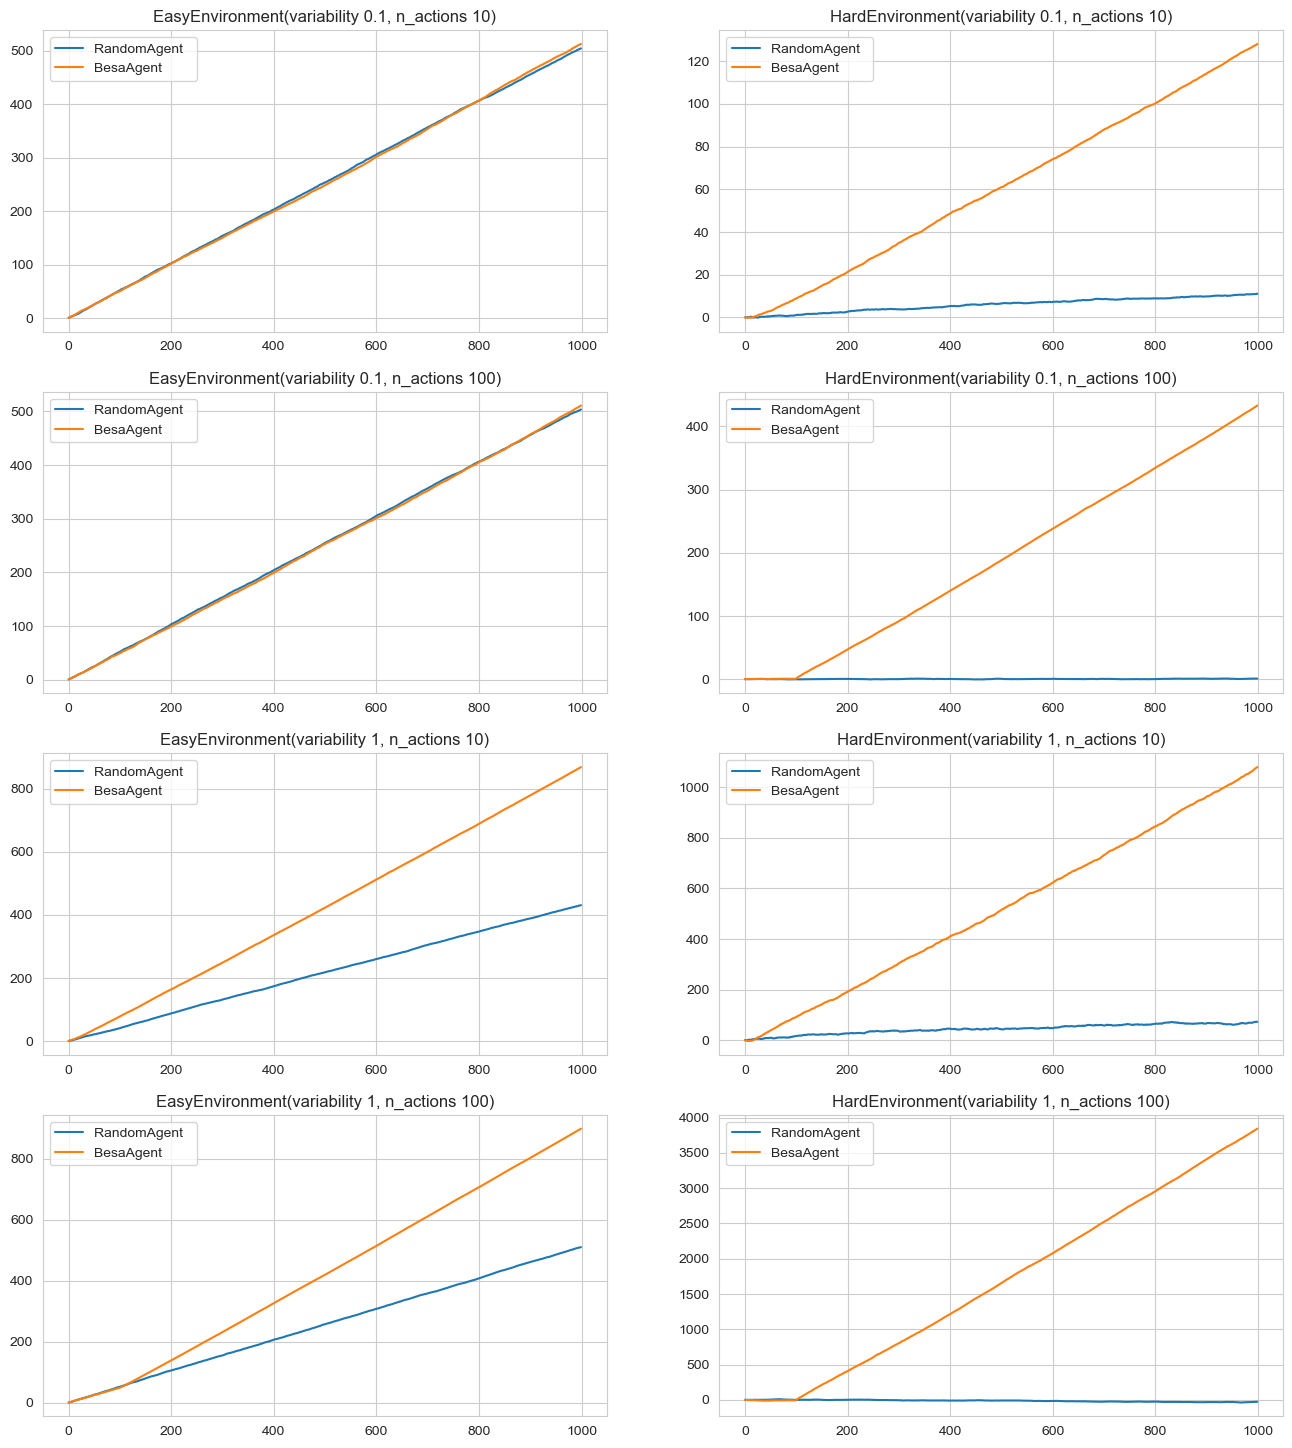

In [27]:
experiment_values(1000, 10,RandomAgent, BesaAgent, None)

* In the Easy Environment, same old story like in the previous ones 

* In the Hard Environment, it has similar performanc to the softmax agent. However, it slightly underperforms on environments with low variability and low number of actions. 

### KL-UCB

### General idea 

KL-UCB, like UCB-1 is choosing the model based on the upper confidence bound. The upper confidence bound for each arm a at time t implies finding the supremum over a set based on the divergence between the empiricial distribution and theoretical distribution adjusted by the function which takes into account the total number of played rounds (t) and the number of times the arm has been chosen. 

\begin{align}
A_t = \underset{i}{\text{argmax}} \max \left\{ \tilde{\mu} \in [0, 1] : d\left(\hat{\mu}_i(t - 1), \tilde{\mu}\right) \leq \frac{\log f(t)}{T_i(t - 1)} \right\},

\end{align}

<b>Pros</b>: Offers robus theoretical foundation, matching the lower bounds of the regret in some scenarios

<b>Cons</b>: The calculation of the upper confidence bounds can be computationally expensive in environments with many arms

#### The first implementation works only for Bernoulli rewards

In [44]:
from scipy.optimize import minimize_scalar

class KLUCBAgent:
    # See: https://hal.archives-ouvertes.fr/hal-00738209v2
    def __init__(self, n_actions):
        self.A = range(n_actions)
        self.mu = {a: [] for a in range(n_actions)}  # Empirical mean
        self.N = {a: 0 for a in range(n_actions)}  # Number of times each action was chosen
        self.t = 0  # Time step
        self.n_actions = n_actions

    def kl_divergence_bernoulli(self, p, q):
        # Protect against division by zero and log of zero
        p = min(max(p, 1e-15), 1 - 1e-15)
        q = min(max(q, 1e-15), 1 - 1e-15)

        # Compute KL divergence
        return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
    
    def ucb(self, mu_hat, n, t):
        

        upper_bound = 1
        
        # If the empirical mean is equal to the upper bound, we cannot go further than that
        if mu_hat == 1:
            return 1

        f_t = 1 + t * np.log(t)**2
        
        value = mu_hat 

        # The KL divergence function is convex. Therefore, we can use binary search to find the upper bound 
        # I include a small margin of error to avoid numerical issues (I actually encountered some because the numbers do not matct at every decimal)
        while upper_bound - value > 1e-15: 
            mid = (value + upper_bound) / 2

            # if the KL divergence is greater than the upper bound, we need to go lower
            if self.kl_divergence_bernoulli(mu_hat, mid) > (np.log(f_t) / n):
                upper_bound = mid
            else: 
                # otherwise we need to go higher
                value = mid
        
        return upper_bound


    def choose(self):
        """Acts in the environment.

        returns the chosen action.
        """
        self.t += 1

        if self.t <= self.n_actions:  # Choose each arm once
            action = self.t-1
        else:
            ucb_values = []
            for a in range(self.n_actions):
                    
                    #if the arm has not be played yet, its mean is 0
                    mu_hat = np.mean(self.mu[a]) if self.N[a] > 0 else 0

                    #compute the ucb value for the arm and append it to the list
                    ucb_values.append(self.ucb(mu_hat, self.N[a], self.t))
            
            #choose the arm with the highest ucb value
            action = np.argmax(ucb_values)

        
        return action

    def update(self, a, r):
        """Receive a reward for performing given action on
        given observation.

        This is where your agent can learn.
        """
        self.N[a] += 1     
        self.mu[a].append(r)

#### Generalized implementation

We don't have any information related to the offset and scale of the arms. Therefore, we will conduct an exploration such that we can estimate the minimum and maximum value for each arm. Afterwards, we can compute the success rate of each arm as the number of times it got the maximum value divided by the total trials. Then, we solve the optimization problem as we previously did and we rescale the result as: 

\begin{align}
 min_{value}[arm] + (max_{value}[arm] - min_{value}[arm])*solution  
    
\end{align}

In [55]:
class KLUCBAgent2:
    # See: https://hal.archives-ouvertes.fr/hal-00738209v2
    def __init__(self, n_actions, initial_exploration = 1/4):
        self.A = range(n_actions)
        self.mu = {a: [] for a in range(n_actions)}  # Empirical mean
        self.N = {a: 0 for a in range(n_actions)}  # Number of times each action was chosen
        self.min_reward ={a: np.infty for a in range(n_actions)} # Minimum reward obtained by each arm
        self.max_reward ={a: -np.infty for a in range(n_actions)} # Maximum reward obtained by each arm
        self.t = 0  # Time step
        self.n_actions = n_actions
        self.initial_exploration = int(n_actions * initial_exploration)

    def kl_divergence_bernoulli(self, p, q):
        # Protect against division by zero and log of zero
        p = min(max(p, 1e-15), 1 - 1e-15)
        q = min(max(q, 1e-15), 1 - 1e-15)

        # Compute KL divergence
        return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
    
    def ucb(self, mu_hat, n, t):
        upper_bound = 1
        
        # If the empirical mean is equal to the upper bound, we cannot go further than that
        if mu_hat == 1:
            return 1

        f_t = 1 + t * np.log(t)**2
        value = mu_hat 

        # The KL divergence function is convex. Therefore, we can use binary search to find the upper bound 
        # I include a small margin of error to avoid numerical issues (I actually encountered some because the numbers do not matct at every decimal)
        while upper_bound - value > 1e-15: 
            mid = (value + upper_bound) / 2

            if self.kl_divergence_bernoulli(mu_hat, mid) > (np.log(f_t) / n):
                upper_bound = mid
            else: 
                value = mid

            # print(upper_bound, value)
        
        return upper_bound


    def choose(self):
        """Acts in the environment.

        returns the chosen action.
        """
        self.t += 1

        if self.t <= self.n_actions:  # Choose each arm once
            return self.t-1
        elif self.t <= self.initial_exploration: # Explore for the first 50 steps
            return np.random.choice(self.A)
        else:
            ucb_values = []
            for a in range(self.n_actions):
                    
                    #if the arm has not be played yet, its mean is 0

                    successes = sum([r == self.max_reward[a] for r in self.mu[a]])
                    total = len(self.mu[a])
                    success_rate = successes / total

                    #compute the ucb value for the arm and append it to the list
                    ucb_value = self.ucb(success_rate, self.N[a], self.t)
                    scaled_ucb = self.min_reward[a] + (self.max_reward[a] - self.min_reward[a]) * ucb_value
                    ucb_values.append(scaled_ucb)

            
            #choose the arm with the highest ucb value
            action = np.argmax(ucb_values)

        
        return action

    def update(self, a, r):
        """Receive a reward for performing given action on
        given observation.

        This is where your agent can learn.
        """
        self.N[a] += 1     
        self.mu[a].append(r)

        self.min_reward[a] = min(self.min_reward[a], r)
        self.max_reward[a] = max(self.max_reward[a], r)

> Analysis of KL-UCB

In [45]:
niter = 1000
n_agents = 10
n_actions = 10
variability = 1
my_runner = runner.BatchRunner(
    environment.EasyEnvironment,
    KLUCBAgent,
    n_agents,
    n_actions,
    {"variability": variability},
    None,
    verbose=False,
)
final_reward_rd, list_cumul_rd = my_runner.loop(niter)
print("KL-UCB obtained a final average reward of {}".format(final_reward_rd))

KL-UCB obtained a final average reward of 854.4999999999924


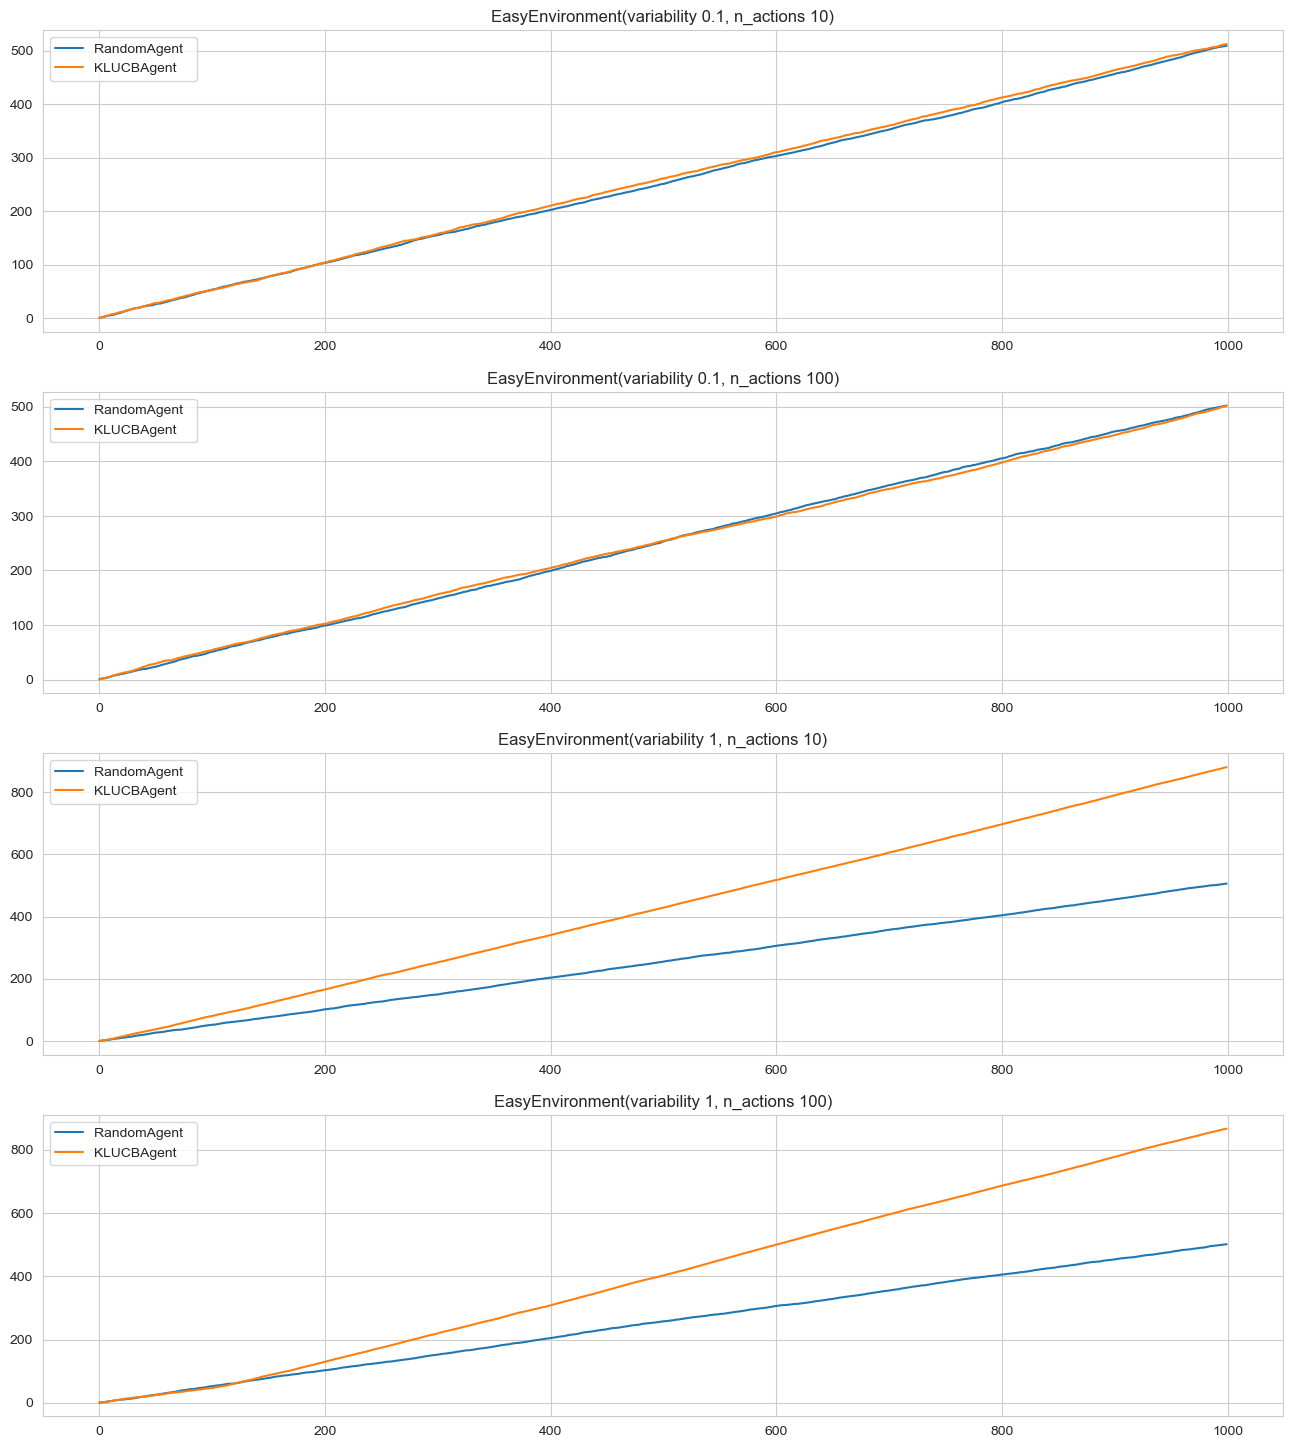

In [59]:
## This one works only on Bernoulli rewards

experiment_values(1000, 5, RandomAgent, KLUCBAgent, None, True)

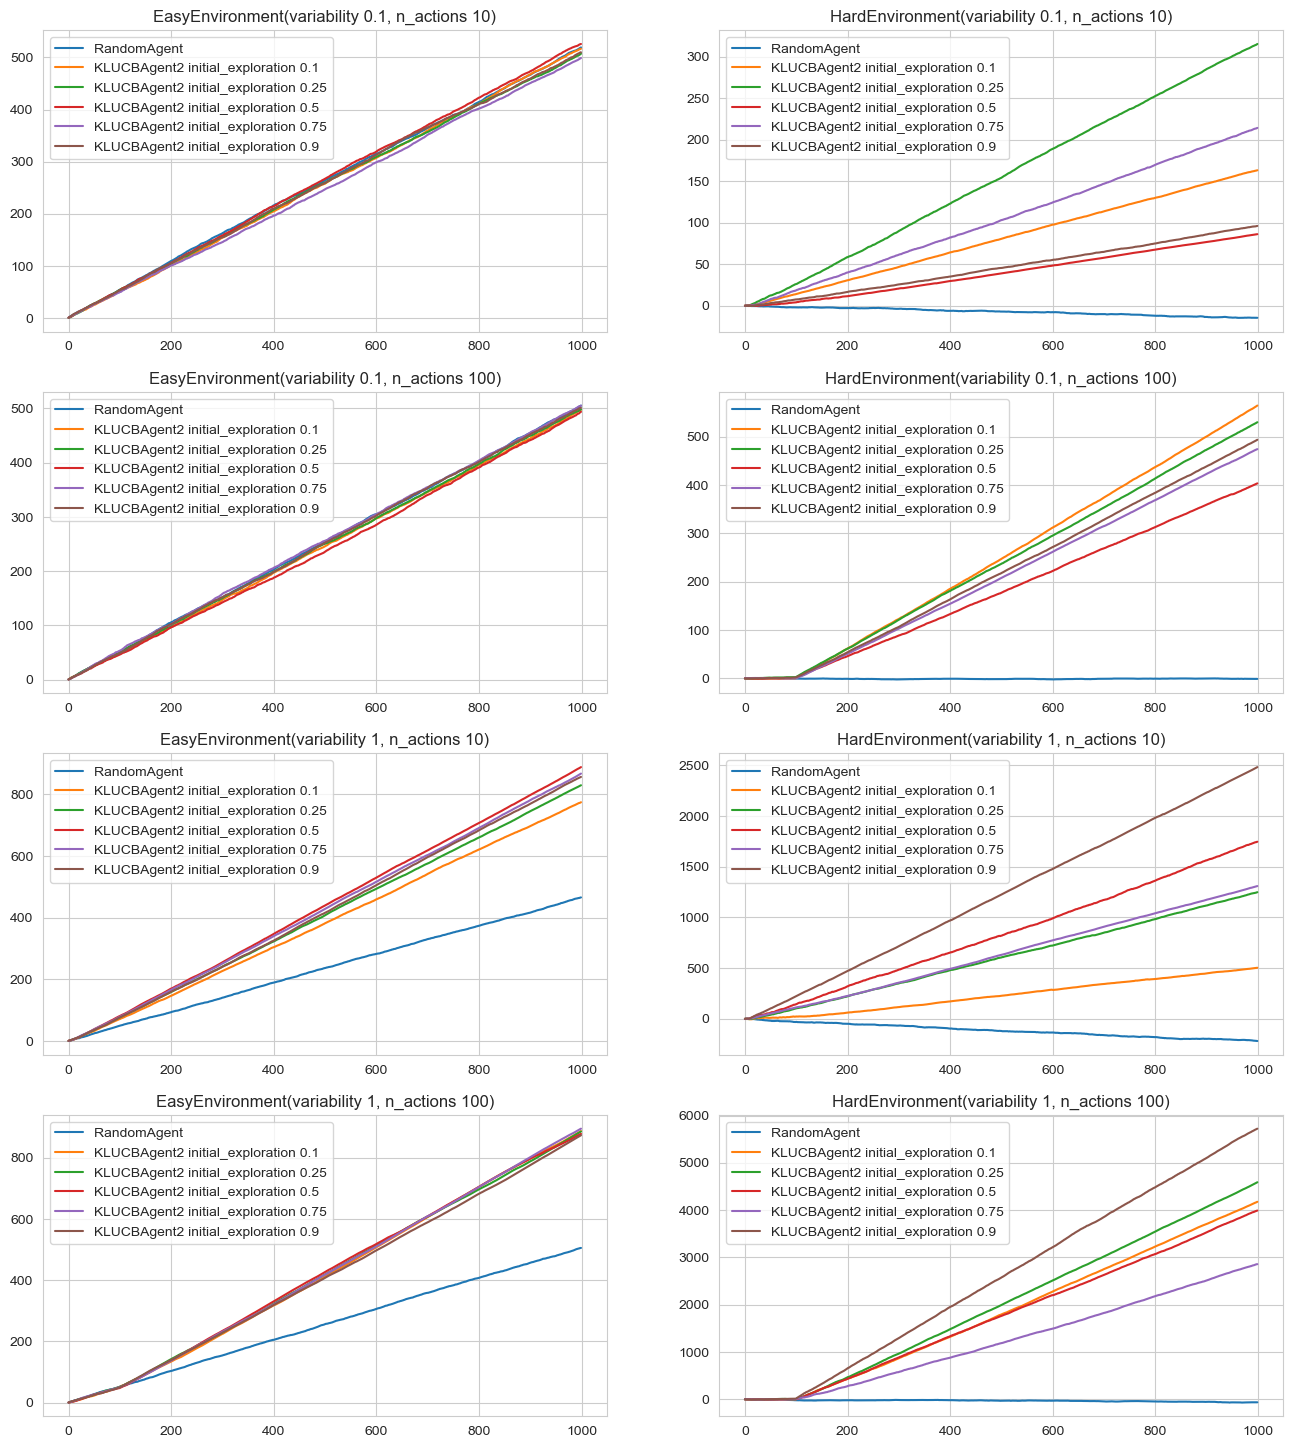

In [60]:
experiment_values(1000,5, RandomAgent, KLUCBAgent2, {"initial_exploration": [0.1, 0.25, 0.5, 0.75]})

* In the Easy Environment, the KL-UCB agent performs much better than the UCB agent whne the variability is higher and there are more actions. 
* In the Hard Environment, the KL-UCB has the highest reward so far (compared to the rest of the algorithms) on the environment with higher variability and higher number of actions. A long exploration proves to be the suitable solution in the long run. 

Overall a longer exploration proves to also be more efficient in environments with high variability and lower number of actions.


### Thompson Sampling

> Try first to implement the Bernoulli Bandit Thompson Sampling algorithm on the ```EasyEnvironment```. https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf
Additional points will be granted for a Thompson Agent on the ```HardEnvironment```

### General idea

It works like a Bayesian model as it is updating the probability distribution of the expected rewards for each actions based on the observed outcomes. Every step, it samples from the posterior distributions of the expected rewards for each arm. The action with the highest sample is always chosen and the agent updates the posterior distribution of that action with respect to the received reward (information) from the latest outcome. In the context of Bernoulli rewards, it suitable to use the Beta distribution.

<b>Pros</b>: It explores more uncertain actions more often, balancing exploration and exploitation

<b>Cons</b>: The performance of Thmpson Sampling can be sensitive to the choice of the prior distribution, which require some knowledge or assumptions about the environment 

In [31]:
from scipy.stats import beta

class ThompsonAgent:
    # https://en.wikipedia.org/wiki/Thompson_sampling
    def __init__(self, n_actions):
        self.A = range(n_actions)

        # alpha and beta are the parameters of the beta distribution
        self.alpha = {a: 1 for a in self.A}
        self.beta = {a: 1 for a in self.A}
        self.t = 0


    def choose(self):
        """Acts in the environment.

        returns the chosen action.
        """
        
        list_mean = []
        for action in self.A: 

            # Sample from the beta distribution
            list_mean.append(beta.rvs(self.alpha[action], self.beta[action]))

        # Choose the action with the highest sample
        return np.argmax(list_mean)

    def update(self, a, r):
        """Receive a reward for performing given action on
        given observation.

        This is where your agent can learn.
        """

        # Update the parameters of the beta distribution
        if r == 1:
            self.alpha[a] += 1
        else:
            self.beta[a] += 1
        self.t += 1


In [32]:
niter = 1000
n_agents = 10
n_actions = 10
variability = 1
my_runner = runner.BatchRunner(
    environment.EasyEnvironment,
    ThompsonAgent,
    n_agents,
    n_actions,
    {"variability": variability},
    None,
    verbose=False,
)
final_reward_rd, list_cumul_rd = my_runner.loop(niter)
print("ThompsonAgent for bernoulli obtained a final average reward of {}".format(final_reward_rd))

ThompsonAgent for bernoulli obtained a final average reward of 886.8999999999929


> Analysis of Thompson Sampling

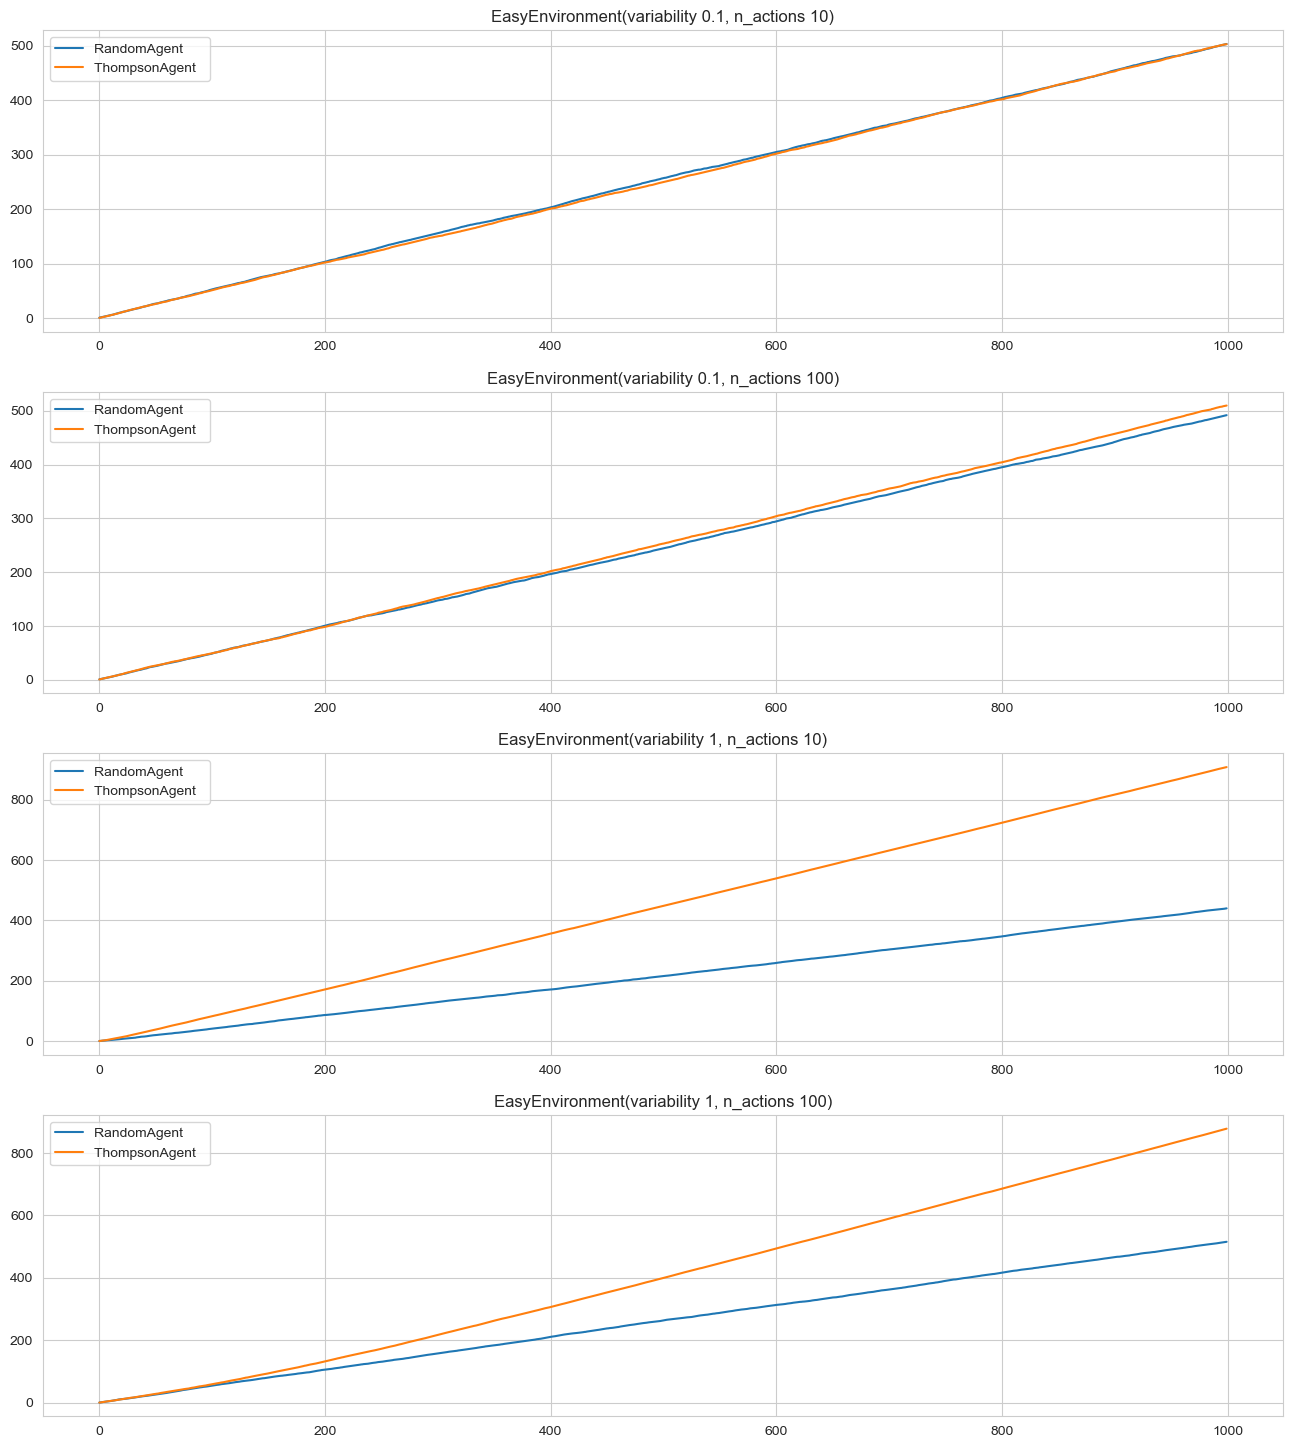

In [33]:
experiment_values(1000, 10, RandomAgent, ThompsonAgent, None, True)

For low variability and many actions, the Thompson sampling is slightly overperforming the random agent. 

Overall, the Thompson sampling performs pretty much the same like most of the previous algorithms. 

One detail which is not seen in the plot is is the fact that the algorithm was much faster than the other ones. It is also very simple to implement.